# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
import time

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN


from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17


In [2]:
X_train = np.loadtxt("datasets/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt("datasets/UCI HAR Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("datasets/UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt("datasets/UCI HAR Dataset/test/y_test.txt").astype(int)

In [3]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [4]:
# Ваш код здесь
X = np.concatenate([X_train, X_test], axis = 0)
y = np.concatenate([y_train, y_test], axis = 0)

Определим число уникальных значений меток целевого класса.

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [6]:
n_classes = np.unique(y).size


[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [7]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [8]:
# Ваш код здесь
pca = PCA(random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)


**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- **65**
- 66
- 193

In [9]:
# Ваш код здесь

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Количество компонент для 90% дисперсии: {n_components_90}")

Количество компонент для 90% дисперсии: 65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- **51**
- 56
- 61

In [10]:
# Ваш код здесь
first_component_variance = pca.explained_variance_ratio_[0] * 100  # в процентах

print(f"Первая главная компонента объясняет {round(first_component_variance)}% дисперсии")

Первая главная компонента объясняет 51% дисперсии


Визуализируйте данные в проекции на первые две главные компоненты.

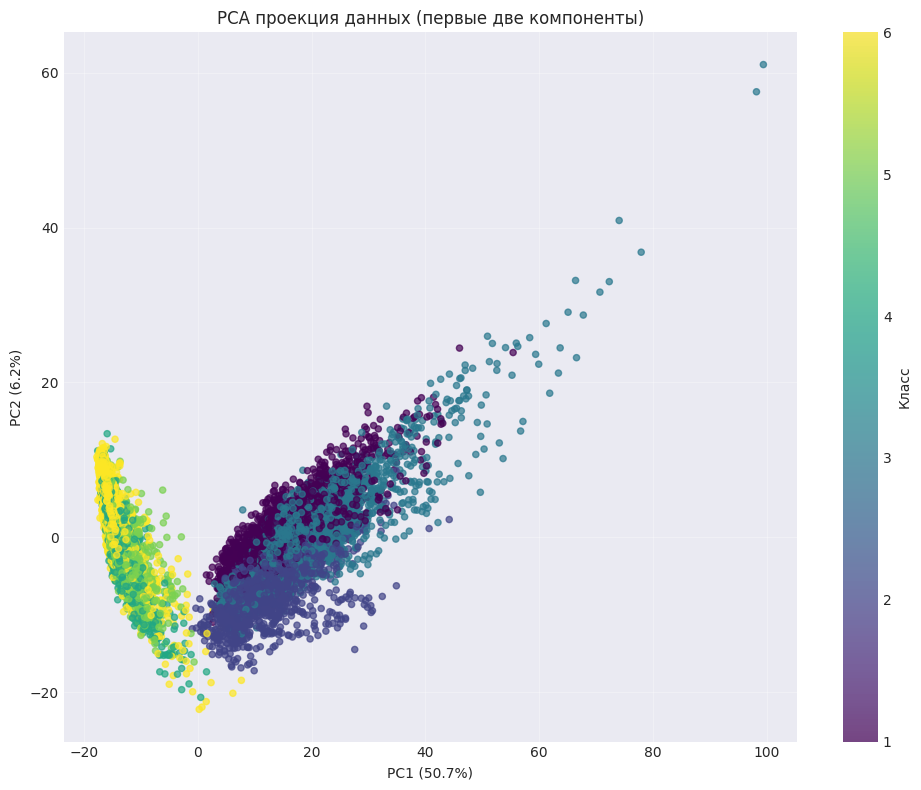

In [11]:
# Ваш код здесь
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis', alpha=0.7)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('PCA проекция данных (первые две компоненты)')
plt.colorbar(label='Класс')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [12]:

kmeans_sklearn = KMeans(
    n_clusters=n_classes,
    n_init=100,
    random_state=RANDOM_STATE,
    max_iter=300
)
start_time = time.time()
kmeans_sklearn.fit(X_pca)
sklearn_time = time.time() - start_time
sklearn_labels = kmeans_sklearn.labels_
sklearn_inertia = kmeans_sklearn.inertia_
sklearn_ari = adjusted_rand_score(y, sklearn_labels)

print("\n--- Готовая реализация (sklearn) ---")
print(f"Время обучения: {sklearn_time:.2f} сек")
print(f"Инерция (WCSS): {sklearn_inertia:.2f}")
print(f"Adjusted Rand Index (ARI): {sklearn_ari:.4f}")

def my_kmeans(X, n_clusters, n_init=1, max_iter=300, tol=1e-4, random_state=None):
    best_inertia = np.inf
    best_centroids = None
    best_labels = None
    rng_global = np.random.default_rng(random_state)
    
    seeds = rng_global.integers(np.iinfo(np.int32).max, size=n_init)
    
    for i in range(n_init):
        seed = seeds[i]
        rng = np.random.default_rng(seed)
        
        indices = rng.choice(X.shape[0], n_clusters, replace=False)
        centroids = X[indices].copy()
        labels = np.zeros(X.shape[0], dtype=int)
        
        for _ in range(max_iter):
            distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
            new_labels = np.argmin(distances, axis=1)
            
            new_centroids = np.empty_like(centroids)
            for j in range(n_clusters):
                cluster_points = X[new_labels == j]
                if len(cluster_points) > 0:
                    new_centroids[j] = cluster_points.mean(axis=0)
                else:
                    new_centroids[j] = X[rng.choice(X.shape[0])]
            
            centroid_shift = np.linalg.norm(new_centroids - centroids)
            centroids = new_centroids
            labels = new_labels
            
            if centroid_shift < tol:
                break
        
        inertia = np.sum((X - centroids[labels]) ** 2)
        
        if inertia < best_inertia:
            best_inertia = inertia
            best_centroids = centroids.copy()
            best_labels = labels.copy()
    
    return best_centroids, best_labels, best_inertia

start_time = time.time()
my_centroids, my_labels, my_inertia = my_kmeans(
    X_pca,
    n_clusters=n_classes,
    n_init=100,
    random_state=RANDOM_STATE
)
my_time = time.time() - start_time
my_ari = adjusted_rand_score(y, my_labels)

print("\n--- Собственная реализация ---")
print(f"Время обучения: {my_time:.2f} сек")
print(f"Инерция (WCSS): {my_inertia:.2f}")
print(f"Adjusted Rand Index (ARI): {my_ari:.4f}")

print("\n--- Сравнение реализаций ---")
print(f"Разница в инерции: {abs(sklearn_inertia - my_inertia):.2f}")
print(f"Разница в ARI: {abs(sklearn_ari - my_ari):.4f}")


--- Готовая реализация (sklearn) ---
Время обучения: 14.30 сек
Инерция (WCSS): 2577051.09
Adjusted Rand Index (ARI): 0.4192

--- Собственная реализация ---
Время обучения: 704.26 сек
Инерция (WCSS): 2577051.09
Adjusted Rand Index (ARI): 0.4192

--- Сравнение реализаций ---
Разница в инерции: 0.00
Разница в ARI: 0.0000


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

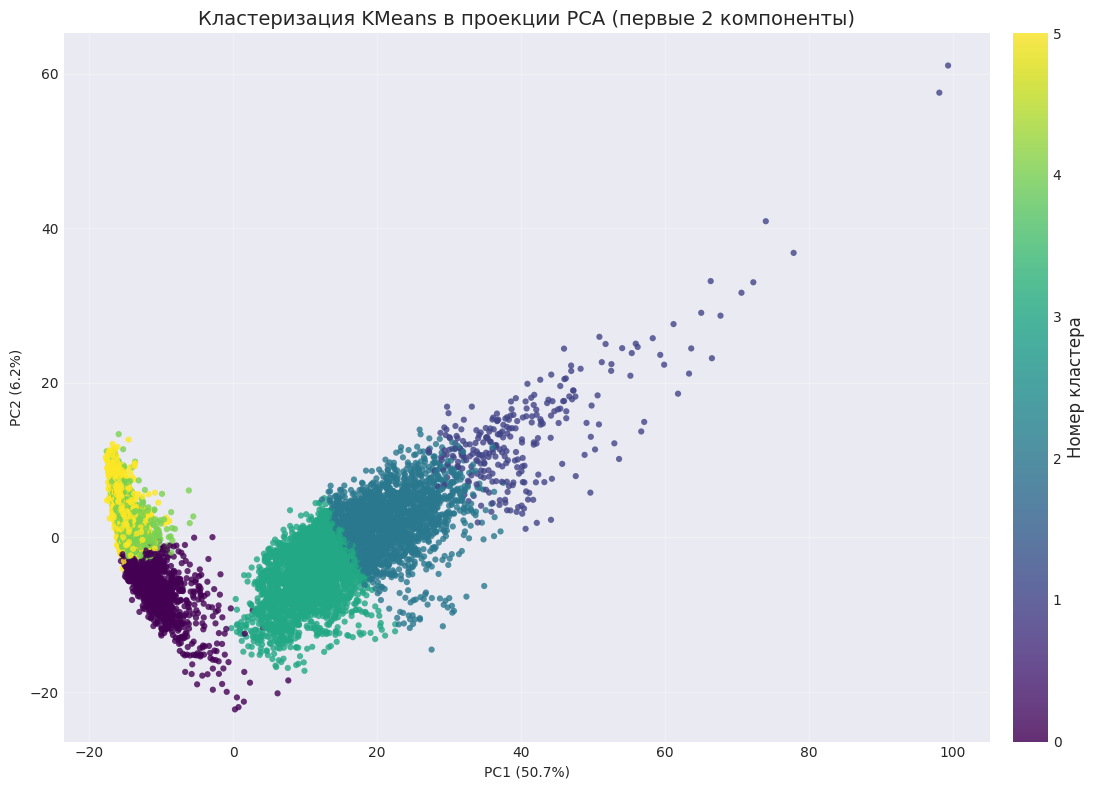

In [13]:
# Ваш код здесь
plt.figure(figsize=(12, 8))

scatter = plt.scatter(
    X_pca[:, 0],         
    X_pca[:, 1],       
    c=my_labels,          
    s=20,                 
    cmap='viridis',      
    alpha=0.8,           
    edgecolor='none'      
)

plt.title('Кластеризация KMeans в проекции PCA (первые 2 компоненты)', fontsize=14)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.grid(alpha=0.3)  

cbar = plt.colorbar(scatter, pad=0.02)
cbar.set_label('Номер кластера', fontsize=12)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [14]:
tab = pd.crosstab(y, my_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,77,742,903,0,0,1722
подъем вверх по лестнице,2,5,295,1242,0,0,1544
спуск по лестнице,0,196,889,321,0,0,1406
сидение,451,0,0,1,1234,91,1777
стояние,566,0,0,0,1340,0,1906
лежание,330,0,0,5,53,1556,1944
все,1349,278,1926,2472,2627,1647,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят**

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

Вычисление инерции для разных значений k...


C:\Users\Артемий Хереш\AppData\Local\Temp\ipykernel_21220\2929211549.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(k_range, desc="Прогресс"):


Прогресс:   0%|          | 0/14 [00:00<?, ?it/s]

([<matplotlib.axis.XTick at 0x26682c9d280>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14')])

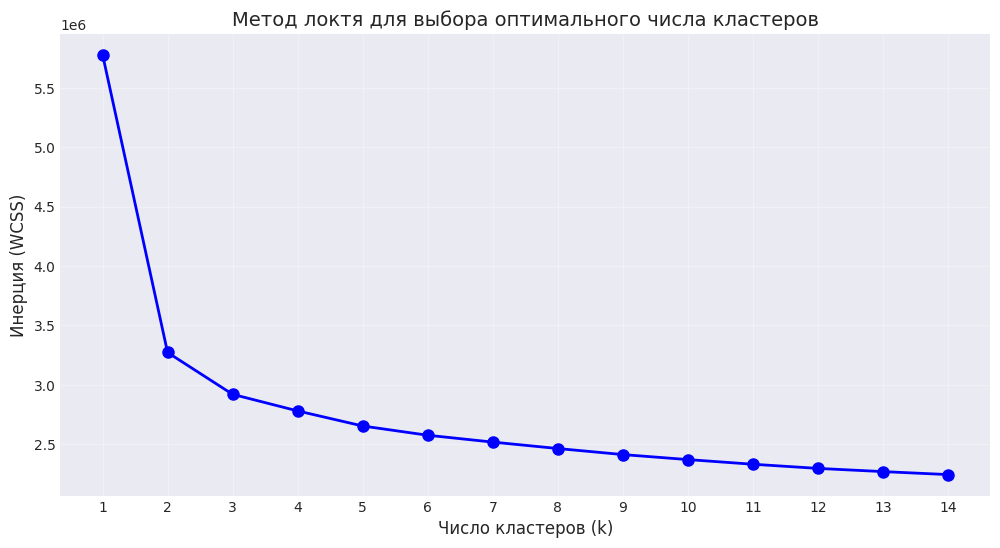

In [15]:
# Ваш код здесь
k_range = range(1, 15)  
inertia = []

print("Вычисление инерции для разных значений k...")
for k in tqdm_notebook(k_range, desc="Прогресс"):
    kmeans = KMeans(
        n_clusters=k,
        n_init=100,
        random_state=RANDOM_STATE,
        max_iter=300
    )
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
plt.title('Метод локтя для выбора оптимального числа кластеров', fontsize=14)
plt.xlabel('Число кластеров (k)', fontsize=12)
plt.ylabel('Инерция (WCSS)', fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(k_range)


**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

2

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [16]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

Adjusted Rand Index (ARI):
Агломеративная кластеризация (ward): 0.4599
KMeans (n_init=100, random_state=17): 0.4192


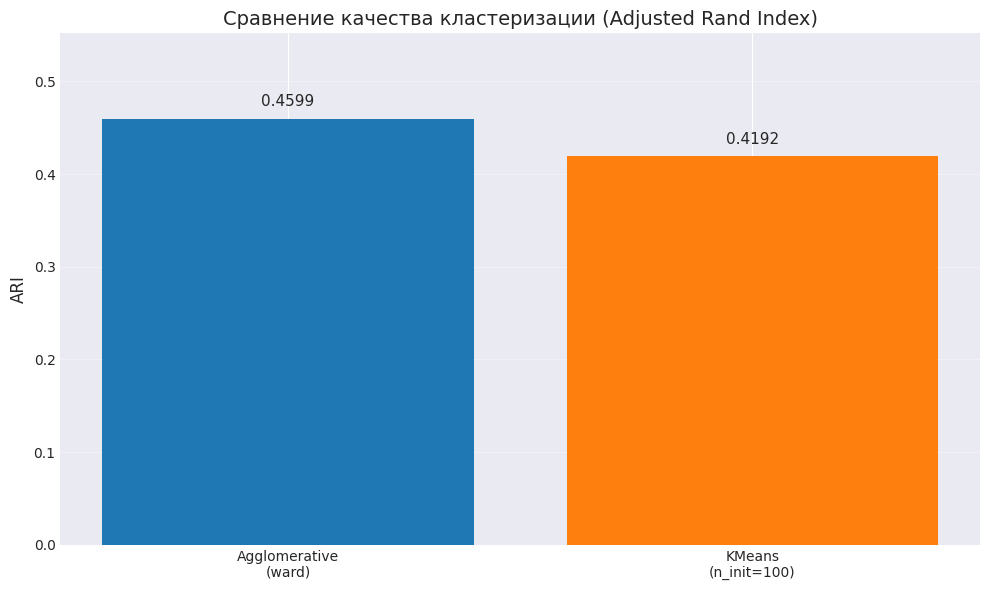


Матрица сопряженности для агломеративной кластеризации:
                          cluster1  cluster2  cluster3  cluster4  cluster5  \
ходьба                        1339       355         0         0        28   
подъем вверх по лестнице      1332       212         0         0         0   
спуск по лестнице              537       746         0         0       123   
сидение                          0         0       529        22         0   
стояние                          0         0       618         6         0   
лежание                          0         0        59      1806         0   
все                           3208      1313      1206      1834       151   

                          cluster6    все  
ходьба                           0   1722  
подъем вверх по лестнице         0   1544  
спуск по лестнице                0   1406  
сидение                       1226   1777  
стояние                       1282   1906  
лежание                         79   1944  
все       

In [17]:
# Ваш код здесь

ag_labels = ag.labels_

kmeans = KMeans(
    n_clusters=n_classes,
    n_init=100,
    random_state=RANDOM_STATE,
    max_iter=300
).fit(X_pca)

kmeans_labels = kmeans.labels_

ag_ari = adjusted_rand_score(y, ag_labels)
kmeans_ari = adjusted_rand_score(y, kmeans_labels)

print("Adjusted Rand Index (ARI):")
print(f"Агломеративная кластеризация (ward): {ag_ari:.4f}")
print(f"KMeans (n_init=100, random_state={RANDOM_STATE}): {kmeans_ari:.4f}")

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
algorithms = ['Agglomerative\n(ward)', 'KMeans\n(n_init=100)']
ari_values = [ag_ari, kmeans_ari]

bars = plt.bar(algorithms, ari_values, color=['#1f77b4', '#ff7f0e'])
plt.ylim(0, max(ari_values) * 1.2)
plt.title('Сравнение качества кластеризации (Adjusted Rand Index)', fontsize=14)
plt.ylabel('ARI', fontsize=12)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom', fontsize=11)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

ag_tab = pd.crosstab(y, ag_labels, margins=True)
ag_tab.index = ['ходьба', 'подъем вверх по лестнице', 
               'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
ag_tab.columns = [f'cluster{i+1}' for i in range(n_classes)] + ['все']

print("\nМатрица сопряженности для агломеративной кластеризации:")
print(ag_tab)

def max_cluster_ratio(contingency_table):
    """Рассчитывает максимальную долю объектов в классе, отнесенных к одному кластеру"""
    ratios = []
    for i in range(len(contingency_table)-1): 
        row = contingency_table.iloc[i, :-1] 
        max_ratio = row.max() / row.sum()
        ratios.append(max_ratio)
    return ratios

ag_ratios = max_cluster_ratio(ag_tab)

kmeans_tab = tab  
kmeans_ratios = max_cluster_ratio(kmeans_tab)

comparison_df = pd.DataFrame({
    'Активность': ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
                  'сидение', 'стояние', 'лежание'],
    'Agglomerative (max ratio)': ag_ratios,
    'KMeans (max ratio)': kmeans_ratios
})

print("\nСравнение максимальных долей для каждого класса:")
print(comparison_df.round(3))

**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

Все утверждения верны.

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [18]:
# Ваш код здесь
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
svc = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid_search = GridSearchCV(
    estimator=svc,
    param_grid=svc_params,
    cv=3,
    scoring='accuracy',  
    n_jobs=-1,           
    verbose=1            
)

grid_search.fit(X_train_scaled, y_train)

best_svc = grid_search.best_estimator_

print("Лучший параметр C:", grid_search.best_params_)
print("Лучшая точность на кросс-валидации:", grid_search.best_score_)
print("Результаты для всех параметров:")
results = pd.DataFrame(grid_search.cv_results_)
display(results[['param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']])

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Лучший параметр C: {'C': 0.1}
Лучшая точность на кросс-валидации: 0.9379785010699506
Результаты для всех параметров:


,param_C,mean_test_score,std_test_score,rank_test_score
0,0.001,0.925465,0.021100,4
1,0.010,0.935938,0.014831,2
2,0.100,0.937979,0.013634,1
3,1.000,0.931178,0.014482,3
4,10.000,0.920024,0.011846,5


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – сидение, по полноте – стояние

Ни один ответ не является верным.

In [20]:
y_predicted = best_svc.predict(X_test_scaled)

tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
               'сидение', 'стояние', 'лежание', 'все']

metrics_manual = []
for i, activity in enumerate(['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 'сидение', 'стояние', 'лежание']):
    tp = tab.iloc[i, i]
    
    fp = tab.iloc[6, i] - tp
    
    fn = tab.iloc[i, 6] - tp
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    metrics_manual.append({
        'класс': activity,
        'precision': precision,
        'recall': recall,
        'TP': tp,
        'FP': fp,
        'FN': fn
    })

metrics_df = pd.DataFrame(metrics_manual)
metrics_df = metrics_df.sort_values('precision')

print("\nРезультаты ручного расчета метрик:")
print(metrics_df[['класс', 'precision', 'recall']].round(3))

print("\nХудший класс по точности:", metrics_df.iloc[0]['класс'])
print("Худший класс по полноте:", metrics_df.sort_values('recall').iloc[0]['класс'])


Результаты ручного расчета метрик:
                      класс  precision  recall
4                   стояние      0.878   0.972
3                   сидение      0.964   0.868
0                    ходьба      0.972   0.996
1  подъем вверх по лестнице      0.979   0.975
2         спуск по лестнице      1.000   0.983
5                   лежание      1.000   0.980

Худший класс по точности: стояние
Худший класс по полноте: сидение


Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- **Качество одинаковое**
- 2%
- 4%
- 10%
- 20%


In [21]:
pca = PCA(random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Исходная размерность: {X_train_scaled.shape[1]} признаков")
print(f"Размерность после PCA: {X_train_pca.shape[1]} компонент")
print(f"Доля сохраненной дисперсии: {sum(pca.explained_variance_ratio_):.4f}")

svc = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid_search_pca = GridSearchCV(
    estimator=svc,
    param_grid=svc_params,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_pca.fit(X_train_pca, y_train)

best_score_pca = grid_search_pca.best_score_
best_C_pca = grid_search_pca.best_params_['C']

print(f"\nPCA + LinearSVC:")
print(f"Лучшее значение C: {best_C_pca}")
print(f"Лучшая точность на кросс-валидации: {best_score_pca:.4f}")
print(f"Время обучения: {grid_search_pca.refit_time_:.2f} секунд")


best_score_original = 0.9379785010699506  

difference = abs(best_score_original - best_score_pca) * 100
difference_rounded = round(difference)


print(f"С PCA: {best_score_pca:.4f}")

print(f"\nОтвет на вопрос 9: {difference_rounded}%")

Исходная размерность: 561 признаков
Размерность после PCA: 561 компонент
Доля сохраненной дисперсии: 1.0000
Fitting 3 folds for each of 5 candidates, totalling 15 fits

PCA + LinearSVC:
Лучшее значение C: 0.1
Лучшая точность на кросс-валидации: 0.9378
Время обучения: 2.44 секунд
С PCA: 0.9378

Ответ на вопрос 9: 0%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- <Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

1. СРАВНЕНИЕ КАЧЕСТВА И ВРЕМЕНИ SVM С PCA И БЕЗ
Время обучения (все признаки): 34.49 секунд
Лучшее качество на кросс-валидации: 0.9380

Обучение SVM с PCA (95% дисперсии)...
Количество компонент после PCA: 102
Время обучения (PCA): 1.74 секунд
Лучшее качество на кросс-валидации: 0.9192

Разница в качестве: 1.88%
Ускорение обучения: в 19.9 раз


2. СРАВНЕНИЕ PCA И T-SNE ДЛЯ ВИЗУАЛИЗАЦИИ

Сравнение на подвыборке из 1000 объектов

Запуск PCA...
PCA завершен за 0.01 секунд
Объясненная дисперсия: 57.4%
t-SNE завершен за 2.01 секунд


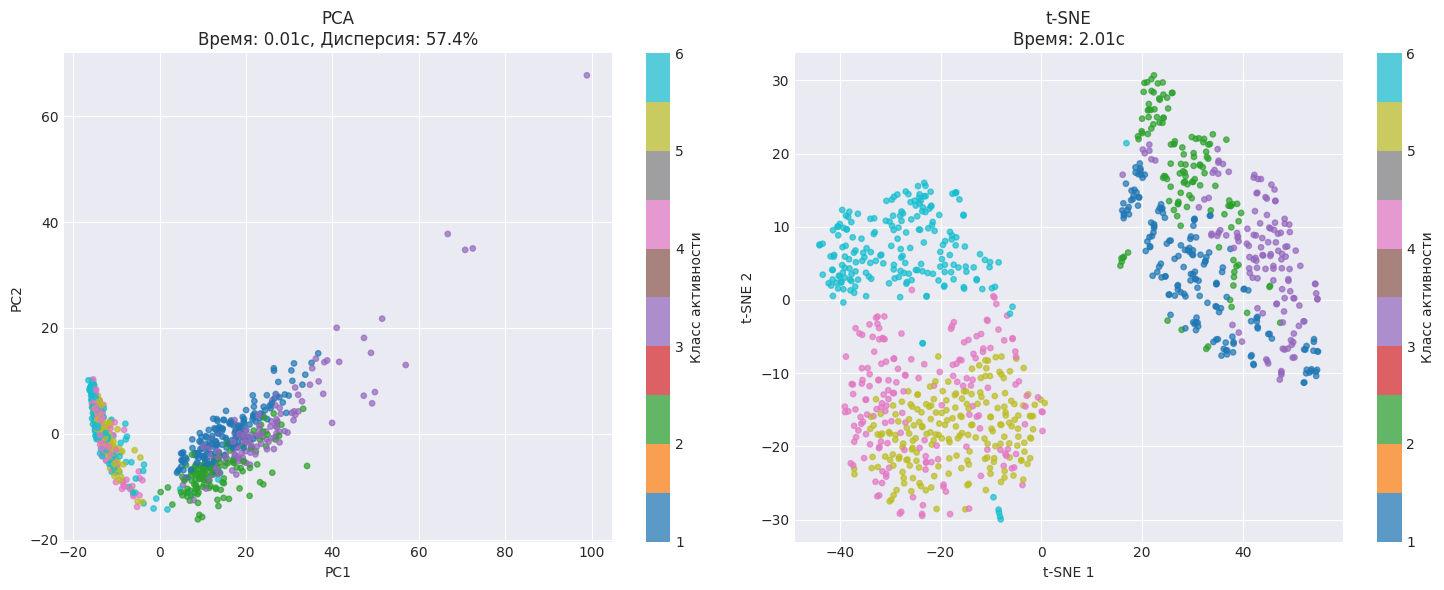


Сравнение времени: t-SNE работает в 167.3 раз дольше PCA


3. ПРОБЛЕМА ИНТЕРПРЕТИРУЕМОСТИ ГЛАВНЫХ КОМПОНЕНТ

Первые 3 главные компоненты и их вклад исходных признаков:
(Показаны топ-5 признаков для каждой компоненты)

PC1 (объясняет 50.8% дисперсии):
  Наибольшие положительные вклады:
    feature_280: 0.989
    feature_359: 0.989
    feature_95: 0.988
    feature_438: 0.988
    feature_226: 0.987
  Наибольшие отрицательные вклады:
    feature_12: -0.950
    feature_13: -0.941
    feature_92: -0.938
    feature_93: -0.926
    feature_94: -0.920

PC2 (объясняет 6.6% дисперсии):
  Наибольшие положительные вклады:
    feature_295: 0.744
    feature_248: 0.728
    feature_209: 0.718
    feature_222: 0.718
    feature_512: 0.716
  Наибольшие отрицательные вклады:
    feature_74: -0.712
    feature_76: -0.681
    feature_249: -0.680
    feature_210: -0.650
    feature_223: -0.650

PC3 (объясняет 2.8% дисперсии):
  Наибольшие положительные вклады:
    feature_56: 0.437
    feature_65: 0.436
 

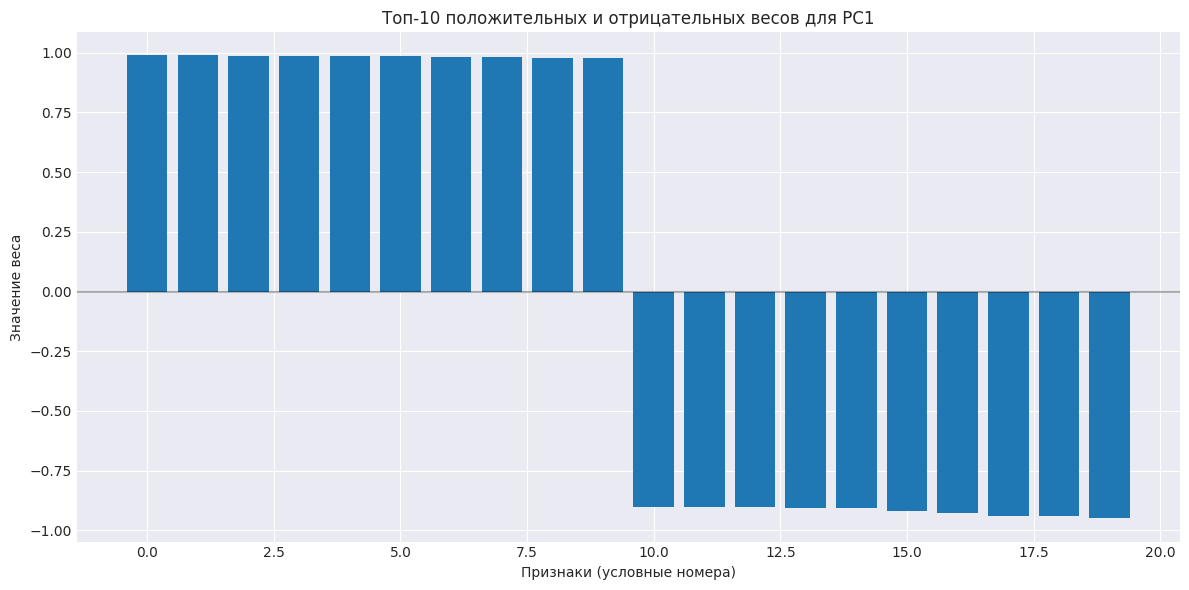

In [22]:
def compare_pca_vs_full():
    print("="*60)
    print("1. СРАВНЕНИЕ КАЧЕСТВА И ВРЕМЕНИ SVM С PCA И БЕЗ")
    print("="*60)
    
    start_time_full = time.time()
    
    svc_full = LinearSVC(random_state=RANDOM_STATE, max_iter=5000)
    params = {'C': [0.1, 1, 10]}
    grid_full = GridSearchCV(svc_full, params, cv=3, n_jobs=-1)
    grid_full.fit(X_train_scaled, y_train)
    
    time_full = time.time() - start_time_full
    best_score_full = grid_full.best_score_
    
    print(f"Время обучения (все признаки): {time_full:.2f} секунд")
    print(f"Лучшее качество на кросс-валидации: {best_score_full:.4f}")
    
    print("\nОбучение SVM с PCA (95% дисперсии)...")
    pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
    X_train_pca = pca.fit_transform(X_train_scaled)
    
    start_time_pca = time.time()
    
    svc_pca = LinearSVC(random_state=RANDOM_STATE, max_iter=5000)
    grid_pca = GridSearchCV(svc_pca, params, cv=3, n_jobs=-1)
    grid_pca.fit(X_train_pca, y_train)
    
    time_pca = time.time() - start_time_pca
    best_score_pca = grid_pca.best_score_
    
    print(f"Количество компонент после PCA: {X_train_pca.shape[1]}")
    print(f"Время обучения (PCA): {time_pca:.2f} секунд")
    print(f"Лучшее качество на кросс-валидации: {best_score_pca:.4f}")
    
    quality_diff = abs(best_score_full - best_score_pca) * 100
    speedup = time_full / time_pca if time_pca > 0 else 0
    
    print(f"\nРазница в качестве: {quality_diff:.2f}%")
    print(f"Ускорение обучения: в {speedup:.1f} раз")
    
    assert quality_diff < 10, "Разница в качестве более 10% - утверждение верно"


def compare_pca_vs_tsne():
    print("\n\n" + "="*60)
    print("2. СРАВНЕНИЕ PCA И T-SNE ДЛЯ ВИЗУАЛИЗАЦИИ")
    print("="*60)
    
    sample_size = 1000
    indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
    X_sample = X_train_scaled[indices]
    y_sample = y_train[indices]
    
    print(f"\nСравнение на подвыборке из {sample_size} объектов")
    
    print("\nЗапуск PCA...")
    start_time_pca = time.time()
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_sample)
    time_pca = time.time() - start_time_pca
    explained_variance = sum(pca.explained_variance_ratio_) * 100
    
    print(f"PCA завершен за {time_pca:.2f} секунд")
    print(f"Объясненная дисперсия: {explained_variance:.1f}%")
    
    start_time_tsne = time.time()
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X_sample)
    time_tsne = time.time() - start_time_tsne
    
    print(f"t-SNE завершен за {time_tsne:.2f} секунд")
    
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                         c=y_sample, cmap='tab10', s=15, alpha=0.7)
    plt.colorbar(scatter, label='Класс активности')
    plt.title(f'PCA\nВремя: {time_pca:.2f}с, Дисперсия: {explained_variance:.1f}%')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    
    plt.subplot(1, 2, 2)
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                         c=y_sample, cmap='tab10', s=15, alpha=0.7)
    plt.colorbar(scatter, label='Класс активности')
    plt.title(f't-SNE\nВремя: {time_tsne:.2f}с')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    
    plt.tight_layout()
    plt.show()
    
    speed_ratio = time_tsne / time_pca if time_pca > 0 else 0
    
    print(f"\nСравнение времени: t-SNE работает в {speed_ratio:.1f} раз дольше PCA")

def demonstrate_pca_interpretability():
    print("\n\n" + "="*60)
    print("3. ПРОБЛЕМА ИНТЕРПРЕТИРУЕМОСТИ ГЛАВНЫХ КОМПОНЕНТ")
    print("="*60)
    
    feature_names = [f'feature_{i}' for i in range(X_train_scaled.shape[1])]
    
    pca = PCA(n_components=3, random_state=RANDOM_STATE)
    pca.fit(X_train_scaled)
    
    print("\nПервые 3 главные компоненты и их вклад исходных признаков:")
    print("(Показаны топ-5 признаков для каждой компоненты)")
    
    loadings = pd.DataFrame(
        pca.components_.T * np.sqrt(pca.explained_variance_),
        columns=[f'PC{i+1}' for i in range(3)],
        index=feature_names
    )
    
    for i in range(3):
        pc_name = f'PC{i+1}'
        print(f"\n{pc_name} (объясняет {pca.explained_variance_ratio_[i]*100:.1f}% дисперсии):")
        
        top_positive = loadings[pc_name].nlargest(5)
        top_negative = loadings[pc_name].nsmallest(5)
        
        print("  Наибольшие положительные вклады:")
        for feature, value in top_positive.items():
            print(f"    {feature}: {value:.3f}")
        
        print("  Наибольшие отрицательные вклады:")
        for feature, value in top_negative.items():
            print(f"    {feature}: {value:.3f}")

    
    plt.figure(figsize=(12, 6))
    pc1_loadings = loadings['PC1'].sort_values(ascending=False)
    plt.bar(range(20), pc1_loadings[:10].tolist() + pc1_loadings[-10:].tolist())
    plt.title('Топ-10 положительных и отрицательных весов для PC1')
    plt.xlabel('Признаки (условные номера)')
    plt.ylabel('Значение веса')
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()
    


compare_pca_vs_full()

compare_pca_vs_tsne()

demonstrate_pca_interpretability()


**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

t-SNE завершен за 26.61 секунд

Применение DBSCAN
DBSCAN завершен за 0.04 секунд

Результаты DBSCAN:
Число обнаруженных кластеров: 176
Число шумовых точек: 9162 (88.96%)


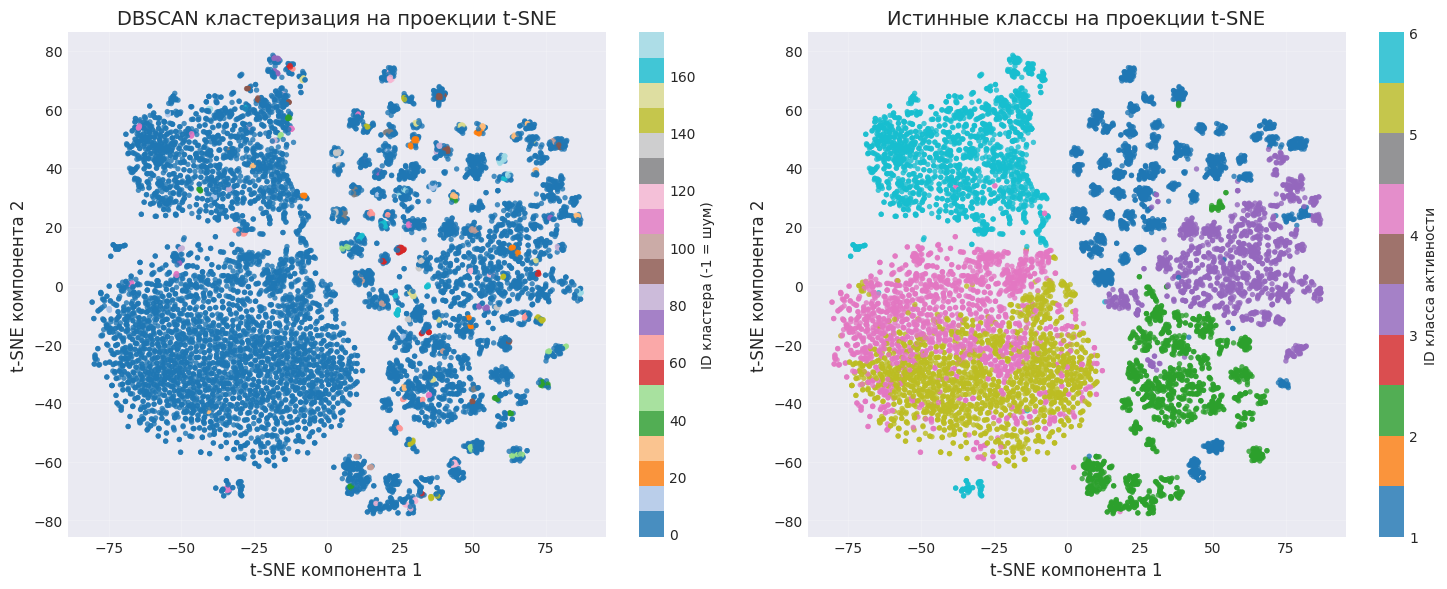


Оценка качества кластеризации (на не-шумовых точках):
Adjusted Rand Index (ARI): 0.0260
Silhouette Score: 0.8044

Эксперимент с параметрами DBSCAN:


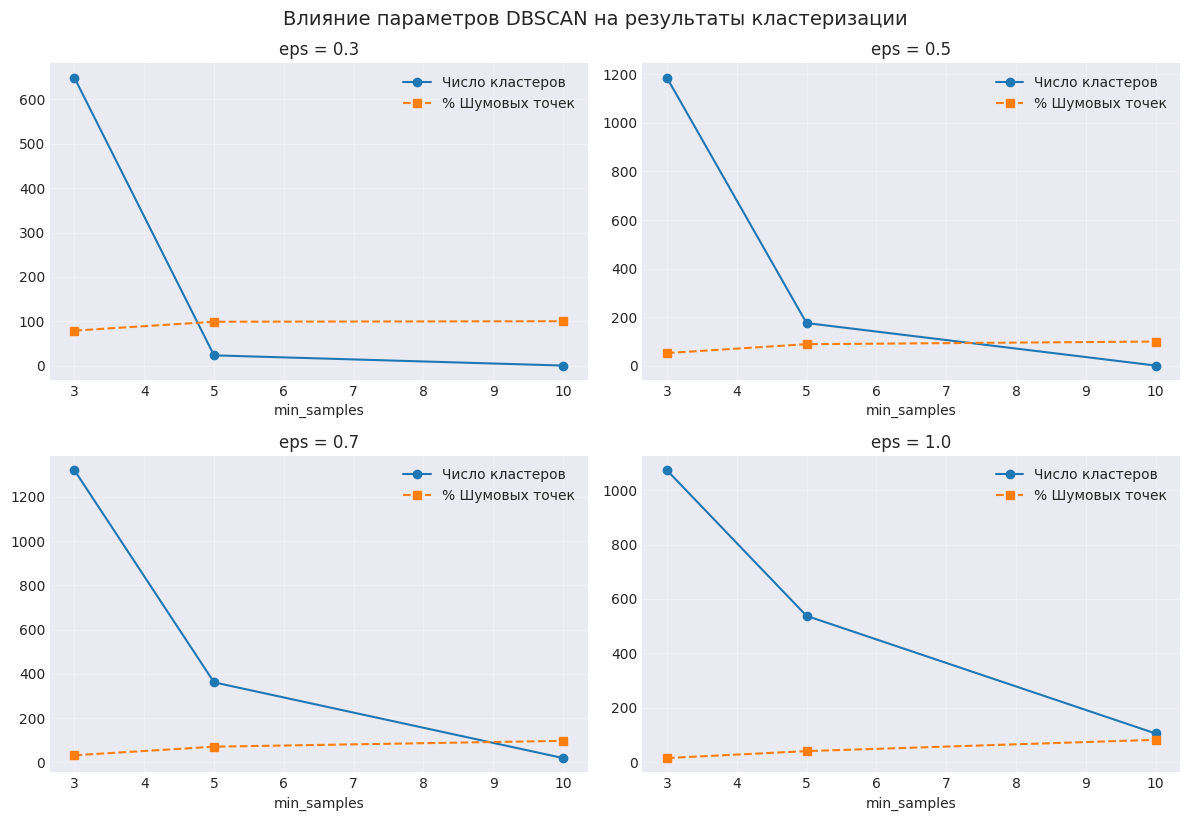

In [23]:
start_time = time.time()
tsne = TSNE(
    n_components=2, 
    random_state=RANDOM_STATE, 
    perplexity=30, 
    learning_rate='auto',
    init='pca'
)
X_tsne = tsne.fit_transform(X_scaled)
tsne_time = time.time() - start_time
print(f"t-SNE завершен за {tsne_time:.2f} секунд")

print("\nПрименение DBSCAN")
start_time = time.time()
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_tsne)
dbscan_time = time.time() - start_time
print(f"DBSCAN завершен за {dbscan_time:.2f} секунд")

n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0) 
noise_points = np.sum(clusters == -1)
noise_ratio = noise_points / len(clusters) * 100

print(f"\nРезультаты DBSCAN:")
print(f"Число обнаруженных кластеров: {n_clusters}")
print(f"Число шумовых точек: {noise_points} ({noise_ratio:.2f}%)")

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
scatter = plt.scatter(
    X_tsne[:, 0], 
    X_tsne[:, 1], 
    c=clusters, 
    s=15, 
    cmap='tab20',
    alpha=0.8,
    edgecolors='none'
)
plt.colorbar(scatter, label='ID кластера (-1 = шум)')
plt.title('DBSCAN кластеризация на проекции t-SNE', fontsize=14)
plt.xlabel('t-SNE компонента 1', fontsize=12)
plt.ylabel('t-SNE компонента 2', fontsize=12)
plt.grid(alpha=0.2)

plt.subplot(1, 2, 2)
scatter = plt.scatter(
    X_tsne[:, 0], 
    X_tsne[:, 1], 
    c=y, 
    s=15, 
    cmap='tab10',
    alpha=0.8,
    edgecolors='none'
)
plt.colorbar(scatter, label='ID класса активности')
plt.title('Истинные классы на проекции t-SNE', fontsize=14)
plt.xlabel('t-SNE компонента 1', fontsize=12)
plt.ylabel('t-SNE компонента 2', fontsize=12)
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

valid_mask = clusters != -1
valid_clusters = clusters[valid_mask]
valid_y = y[valid_mask]

if len(set(valid_clusters)) > 1: 
    ari_score = adjusted_rand_score(valid_y, valid_clusters)
    silhouette_avg = silhouette_score(X_tsne[valid_mask], valid_clusters)
    
    print("\nОценка качества кластеризации (на не-шумовых точках):")
    print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
    print(f"Silhouette Score: {silhouette_avg:.4f}")
else:
    print("\nНедостаточно кластеров для оценки качества (требуется минимум 2 кластера)")

print("\nЭксперимент с параметрами DBSCAN:")
eps_values = [0.3, 0.5, 0.7, 1.0]
min_samples_values = [3, 5, 10]

results = []
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan_test = DBSCAN(eps=eps, min_samples=min_samples)
        clusters_test = dbscan_test.fit_predict(X_tsne)
        n_clusters_test = len(set(clusters_test)) - (1 if -1 in clusters_test else 0)
        noise_ratio_test = np.sum(clusters_test == -1) / len(clusters_test) * 100
        
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters_test,
            'noise_ratio': noise_ratio_test
        })

results_df = pd.DataFrame(results)
plt.figure(figsize=(12, 8))

for i, eps in enumerate(eps_values):
    plt.subplot(2, 2, i+1)
    eps_data = results_df[results_df['eps'] == eps]
    plt.plot(eps_data['min_samples'], eps_data['n_clusters'], 'o-', label='Число кластеров')
    plt.plot(eps_data['min_samples'], eps_data['noise_ratio'], 's--', label='% Шумовых точек')
    plt.title(f'eps = {eps}', fontsize=12)
    plt.xlabel('min_samples')
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle('Влияние параметров DBSCAN на результаты кластеризации', fontsize=14, y=1.02)
plt.show()